In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import math
import csv
import itertools
import scipy.io

# Potts model example

We illustrate how to construct knockoffs from distributions with arbitrary graphical structure using the metroplized knockoff sampling algorithm. Here, we use a graphical model of moderate treewidth taken from a paper about using a graphical model to model protein structure. The original article can be found here: https://journals.aps.org/pre/pdf/10.1103/PhysRevE.87.012707. 

The distribution we use follows a Potts model with probability mass function
$$ P(X) \propto \exp\{\sum_{i} H(X_i) + \sum_{(i,j) \in G} J(X_i,X_j)\}, $$
where $i,j \in \{0,1,\dots,212\}$, $X_i \in \{0,1,\dots,20\}$, and $G$ is a graph with nodes $\{0,1,\dots,212\}$. $H, J$, and $G$ are estimated from data, and we load the parameters provided by the authors.

## Load the distribution

First, we load the distribution from the paper. The following code creates the density function that we will use.  The data we import in this script can be found here: https://www.dropbox.com/sh/ptozr0aqmifiq99/AABLnelHOyvNpEB6Qn0pejl9a?dl=0.

In [3]:
#parameters
keep_const = 0.6 # controls the complexity of the fitted graph

#the Potts model
def Potts_log_density(s, H, J, edges = None):
    # P(s0,s1,...,sN-1) \propto exp(\sum_i H[si,i] + \sum_i<j J[i,j,si,sj])
    ans = 0
    L = len(s)
    
    if edges is None:
        for i in range(L-1):
            for j in range(i+1,L):
                ans+= J[i,j,int(s[i]),int(s[j])]
    else:
        for (i,j) in edges:
            ans+= J[i,j,int(s[i]),int(s[j])]
        
    return(ans)
# sample use of the function (run after you run the entire script):
# Potts_log_density(np.array([0]*N),matH,J,np.array([1]*N),set2)
    
#load the data from the paper
mat = scipy.io.loadmat('DCA/J.mat')
mat = mat['J']
q,q,num = np.shape(mat) # q=21 is # residue types
N = int(0.5+math.sqrt(2*num+0.25)) # N is protein length
J = np.zeros([N,N,q,q])
l = 0
for i in range(N-1):
    for j in range(i+1,N):
        J[i,j,:,:] = mat[:,:,l]
        l = l + 1
        
matH = scipy.io.loadmat('DCA/H.mat')
matH = matH['H']

score_metric = np.zeros([int(N*(N-1)/2),3])
k = 0
with open("DCA/PF00006_scores.txt") as scores:
    tem = csv.reader(scores, delimiter=',')
    for row in tem:
        score_metric[k,:] = int(row[0]), int(row[1]), float(row[2])
        k = k + 1

#create adjacency matrix
adj_mat = np.zeros([N,N])
# sort Jij based on a score
score_metric = score_metric[score_metric[:,2].argsort()[::-1]] 
# keep how many non-zero Jij, which corresponds to an edge
n_keep = math.floor(keep_const*N) 
for i in range(int(N*(N-1)/2)):
	# only the interactions with largest scores (|i-j|>4) 
    # are kept, others set to 0
	if n_keep==0:
		J[int(score_metric[i,0])-1,int(score_metric[i,1])-1,:,:] = \
            np.zeros([q,q])
		continue
	else:
		if abs(int(score_metric[i,0])-int(score_metric[i,1]))>4:
			adj_mat[int(score_metric[i,0])-1,
                    int(score_metric[i,1])-1] = 1
			n_keep = n_keep - 1

#define the graph
G = nx.Graph()
G.add_nodes_from(range(N))
for i in range(N-1):
    for j in range(i+1,N):
        if np.sum(J[i,j,:,:]**2)==0:
            pass
        else:
            G.add_edge(i,j)

The graph from the above distribution is the following:

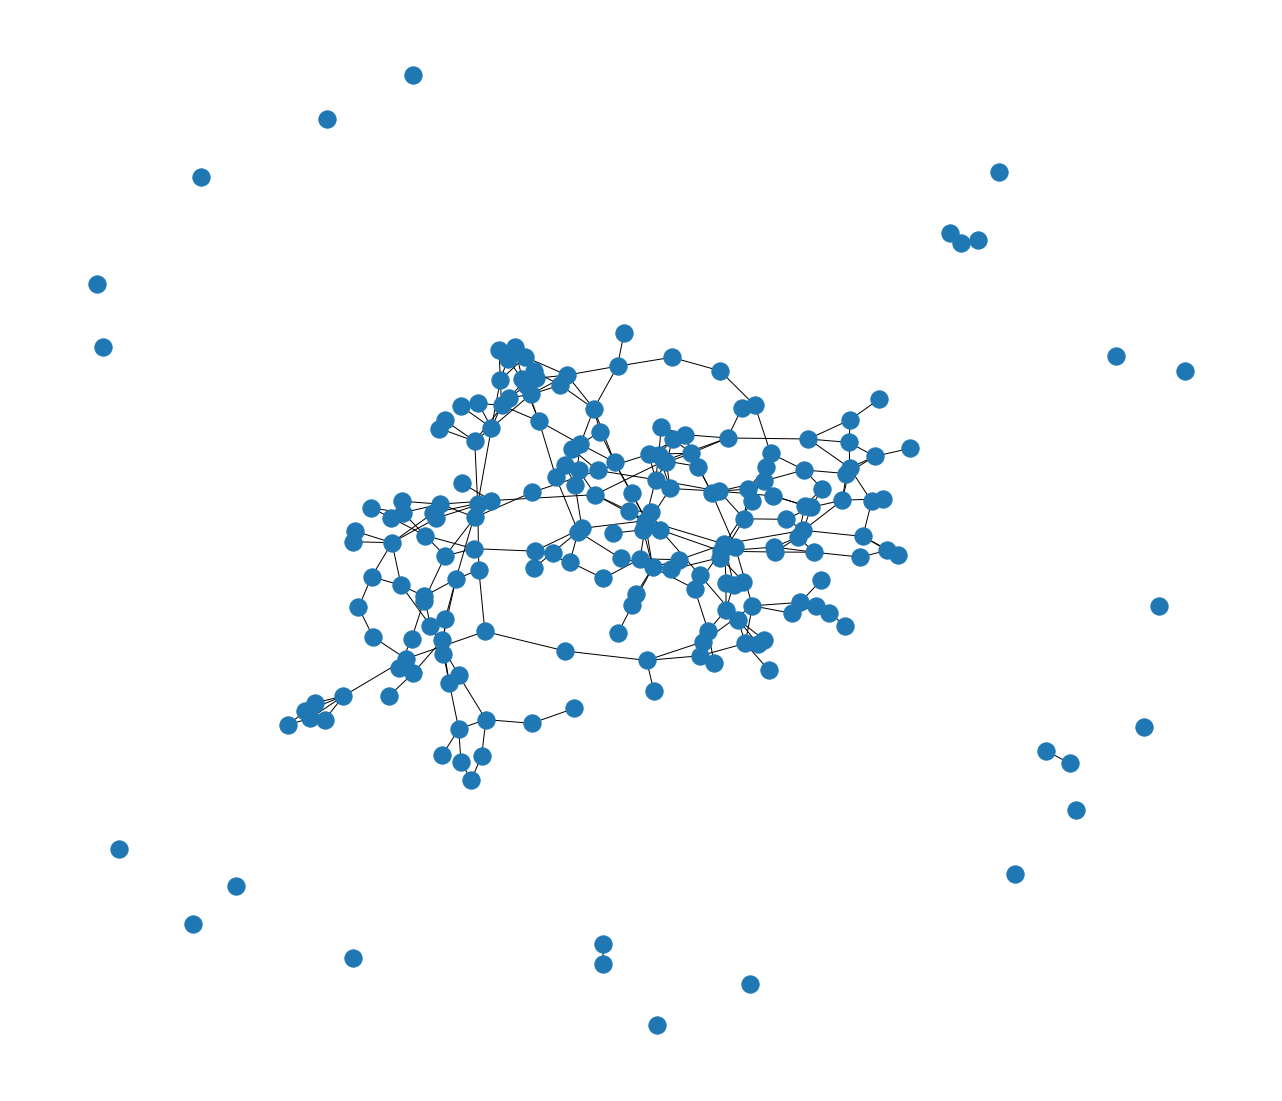

In [4]:
plt.subplot(121)
nx.draw(G, with_labels=False, font_weight='bold')
figure = plt.gcf() # get current figure
figure.set_size_inches(50, 20)
plt.savefig('dca_graph.png')

In [5]:
# The log density function
# note: we multiply by 5 to make a distribution with stronger dependency between 
# variables stronger so that we can more readily verify that the sampled knockoffs 
# exactly match the dependencies in the density function.
edges = G.edges

def lf(x):
    return 5*Potts_log_density(x, matH, J, edges)

In [6]:
#sample from the given density function
def gibbs_sampler(lf, d, n_iter = 10000):
    x_init = np.random.choice(21, size = d)
    x = x_init.copy()
    p_orig = np.exp(lf(x))
    
    lfs = [np.log(p_orig)] #log probabilities, useful for diagnostics
    
    for _ in range(n_iter): 
        j = np.random.choice(d)
        orig = x[j]
        
        #metropolis update with uniformly random proposal
        prop = np.random.choice(21, size = 1)
        if prop == orig:
            continue      
        x[j] = prop
        p_prop = np.exp(lf(x))          
        accept_prob = min(1, p_prop / p_orig)
        u = np.random.uniform()
        if(u < accept_prob):
            p_orig = p_prop
            lfs += [np.log(p_prop)]
        else:
            x[j] = orig
            lfs += [np.log(p_orig)]
    
    return [x, x_init, lfs]

## Find a good metro ordering

Next, we use a tree decomposition to get a good variable ordering for metro. 


In [7]:
#tools to carry out the tree decomposition
import treewidth 
#tools to convert the tree decomposition to a format for metro
import graph_processing

In [8]:
width, T = treewidth.treewidth_decomp(G) #get tree decomposition
#information for the metro sampler
order, active_frontier = graph_processing.get_ordering(T) 

The graph has a moderate treewidth, which governs the runtime of the knockoff sampler.

In [9]:
print("Treewidth: "+ str(width))

Treewidth: 9


## Sample knockoffs

Lastly, we run the knockoff sampler. All we need to specify is the log probability density,
the variabler ordering that is computed from the graphical structure, and a proposal function.  He we use a proposal function that samples uniformly across the 21 possible states.

In [10]:
import metro_generic as metro

In [11]:
#propose uniformly across states
def sym_proposal(j, xj):
    return np.random.choice(21)

In [12]:
%%time
np.random.seed(20000)
#sample the original observation
x, _, _ = gibbs_sampler(lf, 213, n_iter = 20000)

CPU times: user 10.4 s, sys: 64.2 ms, total: 10.5 s
Wall time: 10.6 s


In [13]:
%%time
#sample the knockoff with metro
xk = metro.single_metro(lf, x, order, active_frontier, sym_proposal)

CPU times: user 39.7 s, sys: 214 ms, total: 39.9 s
Wall time: 40.2 s


## Analyze results

Using our knockoff sampler, we generate many repitions of observations and knockoffs from the metro algorithm.  We will then check diagnostics that ensure that the knockoffs are valid, and then compute the knockoff quality measure, MAC.

For convenience, our full simulation data is available at https://www.dropbox.com/s/507nyj7fdionjm7/results.txt?dl=0.

In [14]:
#load simulation results
x = np.loadtxt("results.txt") # 5000 (x, xk) pairs
x.shape

(5000, 426)

In [15]:
# compute the rejection fraction
np.mean(x[:, 0:213] == x[:, 213:])

0.30390140845070424

In [16]:
#check that means match, up to monte carlo error
emp_means = np.mean(x, 0)
np.abs(emp_means[:213] - emp_means[213:])

array([0.0016, 0.0258, 0.0862, 0.155 , 0.0584, 0.0676, 0.037 , 0.1664,
       0.1006, 0.019 , 0.0214, 0.0474, 0.0434, 0.0554, 0.0046, 0.0192,
       0.032 , 0.0102, 0.028 , 0.0024, 0.0922, 0.0146, 0.0882, 0.0042,
       0.0564, 0.1612, 0.155 , 0.0894, 0.0882, 0.0306, 0.0072, 0.0094,
       0.0394, 0.1734, 0.0282, 0.0938, 0.0596, 0.1214, 0.0614, 0.0622,
       0.09  , 0.1158, 0.0266, 0.2302, 0.1076, 0.0158, 0.0398, 0.01  ,
       0.0356, 0.044 , 0.083 , 0.0114, 0.2418, 0.0236, 0.0032, 0.0252,
       0.0232, 0.0592, 0.2312, 0.0092, 0.0306, 0.0858, 0.031 , 0.005 ,
       0.06  , 0.0562, 0.072 , 0.0118, 0.0308, 0.0154, 0.023 , 0.0374,
       0.0184, 0.01  , 0.0816, 0.0772, 0.1454, 0.2078, 0.0272, 0.0628,
       0.0974, 0.111 , 0.0634, 0.101 , 0.1062, 0.0762, 0.054 , 0.2014,
       0.0006, 0.0598, 0.2018, 0.0572, 0.035 , 0.0072, 0.0622, 0.256 ,
       0.1394, 0.1154, 0.0638, 0.0582, 0.085 , 0.0848, 0.035 , 0.0112,
       0.0262, 0.1454, 0.0638, 0.0094, 0.1286, 0.0004, 0.058 , 0.0936,
      

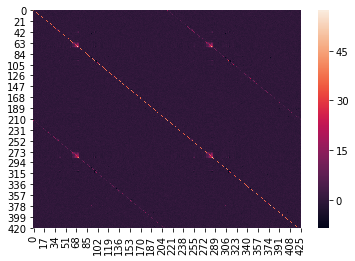

In [17]:
#confirm that the covariance has the knockoff block structure
emp_cov = np.cov(x, rowvar=False)
sns.heatmap(emp_cov)

In [18]:
#compute MAC quality metric
mac = np.mean(np.abs(np.diag(np.corrcoef(x, rowvar = False)[:213, 213:])))
print("MAC: " + str(mac))

MAC: 0.26361414709725456


In this case, the MAC lower bound is .135, so the above MAC indicates that the knockoffs we are constructing are not far from the optimal knockoffs.